In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [40]:
url = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': 'TSLA',
    'outputsize': 'full',
    'apikey': '1SSTSA3XGLWFQLCA'
}

response = requests.get(url, params=params)
# extract the json from the response without the headers and convert it to a dictionary also remove the meta data
data = response.json()['Time Series (Daily)']

In [41]:
# convert the dictionary to a dataframe using
df = pd.read_csv('TSLA.csv')

training_set = df.iloc[:, 1:2].values

print(df.head())

         Date    Open      High       Low   Close     Volume
0  2023-10-16  250.05  255.3999  248.4800  253.92   88917176
1  2023-10-13  258.90  259.6000  250.2200  251.12  102296786
2  2023-10-12  262.92  265.4100  256.6307  258.87  111508114
3  2023-10-11  266.20  268.6000  260.9000  262.99  103706266
4  2023-10-10  257.75  268.9400  257.6500  263.62  122656030


In [42]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

# print the first 5 rows of the scaled training set
print(training_set_scaled)

[[0.10263802]
 [0.10652134]
 [0.10828529]
 ...
 [0.0038877 ]
 [0.00423435]
 [0.00125495]]


In [43]:
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [45]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
62/62 [==============================] - 7s 26ms/step - loss: 0.0074
Epoch 2/100
62/62 [==============================] - 1s 22ms/step - loss: 0.0037
Epoch 3/100
62/62 [==============================] - 1s 23ms/step - loss: 0.0037
Epoch 4/100
62/62 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 5/100
62/62 [==============================] - 1s 21ms/step - loss: 0.0027
Epoch 6/100
62/62 [==============================] - 1s 23ms/step - loss: 0.0026
Epoch 7/100
62/62 [==============================] - 1s 20ms/step - loss: 0.0023
Epoch 8/100
62/62 [==============================] - 1s 22ms/step - loss: 0.0020
Epoch 9/100
62/62 [==============================] - 2s 25ms/step - loss: 0.0019
Epoch 10/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0019
Epoch 11/100
62/62 [==============================] - 2s 26ms/step - loss: 0.0018
Epoch 12/100
62/62 [==============================] - 2s 25ms/step - loss: 0.0016
Epoch 13/100
62/62 [=====

In [51]:
#read only the last 10 days of the stock price
dataset_test = pd.read_csv('TSLAREAL.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [55]:
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
# get the inputs for the test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price)



1/1 [==============================] - 0s 49ms/step
[[ 13.191166]
 [149.7649  ]
 [259.41248 ]
 [297.8302  ]
 [296.1193  ]
 [275.60925 ]
 [255.17606 ]
 [242.15163 ]
 [240.41817 ]
 [235.91464 ]
 [233.55717 ]
 [231.73418 ]
 [234.742   ]
 [232.50107 ]
 [232.78223 ]
 [233.4655  ]
 [234.34888 ]
 [243.18863 ]
 [250.02255 ]
 [257.7929  ]]


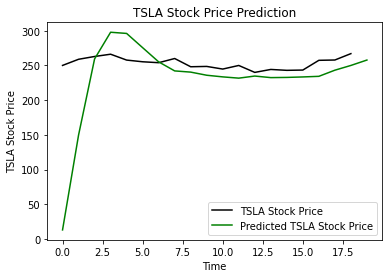

In [56]:
# Visualising the results
plt.plot(real_stock_price, color = 'black', label = 'TSLA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSLA Stock Price')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()